<a href="https://colab.research.google.com/github/superspray/ta-lib/blob/master/Informer_ipynb%EC%9D%98_%EC%82%ACg%EB%B3%B8%EC%9D%98_wti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informer Demo

## Download code and dataset

In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!git clone http://github.com/jingw2/demand_forecast
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 525 (delta 1), reused 5 (delta 1), pack-reused 517
Receiving objects: 100% (525/525), 6.47 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 187 (delta 66), reused 13 (delta 2), pack-reused 0
Receiving objects: 100% (187/187), 3.85 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Cloning into 'demand_forecast'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 254 (delta 27), reused 5 (delta 1), pack-reused 194
Receiving objects: 100% (254/254), 1.06 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (118/118), 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r ./Informer2020/requirements.txt

In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
import pandas as pd
pd.__version__

'1.1.5'

## Experiments: Train and Test

In [ ]:
%cd Informer2020
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import re
%cd ../

[Errno 2] No such file or directory: 'Informer2020'
/content/Informer2020
/content


In [ ]:
%ls

data/  img/     main_informer.py  README.md         scripts/
exp/   LICENSE  models/           requirements.txt  utils/


In [ ]:
def data_pre_inf(nick, dir = "/content/drive/MyDrive/data/naphtha/Crude Oil WTI Futures Historical Data.csv", vol = True):
    data = pd.read_csv(dir)
    if vol:
        if (data.dtypes['Vol.'] == 'O'):
            data['Vol.'] = data['Vol.'].str.rstrip('K')
            data['Vol.'] = data['Vol.'].str.rstrip('M')
            data['Vol.'] = data['Vol.'].replace({'-': 0})
 
            data['Vol.'] = data['Vol.'].astype('float64')#, copy=False)
 
    data['Change %'] = data['Change %'].str.rstrip('%')
    data['Change %'] = data['Change %'].astype('float64')#, copy=False)
    if data.dtypes['Price'] == 'O':
        data['Price'] = data['Price'].map(lambda x: re.sub(r',', '', x))
        data['Price'] = data['Price'].astype('float64')#, copy=False)
 
    data['date'] = pd.to_datetime(data['Date']).astype('datetime64[ns]')
    data = data.drop(['Date'], axis= 1)
    data = data.sort_values(['date'])
    data = data.iloc[:-1,:]
    data = data.replace({'-': 0})
    data = data.drop(["Open", "Low", "High", "Change %"], axis = 1)
    if vol:
        data.columns = ['Price_' + nick, 'Vol_'+nick, 'date']
    else:
        data.columns = ['Price_' + nick, 'date']
 
    print(nick, data.shape)
    return data

In [ ]:
 
dir_list = ["Crude Oil WTI Futures Historical Data.csv",
            "EUR_USD Historical Data.csv",
            "Ethanol Futures Historical Data.csv",
            "GOOGL Historical Data.csv",
            "Natural Gas Futures Historical Data.csv",
            "S&P 500 Historical Data.csv",
            "US 30 Futures Historical Data.csv",
            "United States 10-Year Bond Yield Historical Data.csv",
            "United States 2-Year Bond Yield Historical Data.csv"]
 
data_wti = data_pre_inf("wti","/content/drive/MyDrive/data/naphtha/" + dir_list[0])
data_eur_usd = data_pre_inf("eur_usd", "/content/drive/MyDrive/data/naphtha/" + dir_list[1], vol = False)
data_ethan = data_pre_inf("ethan","/content/drive/MyDrive/data/naphtha/" + dir_list[2])
data_googl = data_pre_inf("googl","/content/drive/MyDrive/data/naphtha/" + dir_list[3])
data_gas = data_pre_inf("gas","/content/drive/MyDrive/data/naphtha/" + dir_list[4])
data_snp500 = data_pre_inf("snp","/content/drive/MyDrive/data/naphtha/" + dir_list[5])
data_us30 = data_pre_inf("us30","/content/drive/MyDrive/data/naphtha/" + dir_list[6])
data_us10bond = data_pre_inf("us10bond","/content/drive/MyDrive/data/naphtha/" + dir_list[7], vol = False)
data_us2bond = data_pre_inf("us2bond","/content/drive/MyDrive/data/naphtha/" + dir_list[8], vol = False)

wti (1868, 3)
eur_usd (1849, 2)
ethan (1785, 3)


NameError: ignored

In [ ]:
 
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,GRU
 
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[:1500], data[1500:1800]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/5))
    test = array(split(test, len(test)/5))
    return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=5):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1],1))# train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)
 
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 30, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(GRU(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], 1))#data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [ ]:
 
train, test = split_dataset(data_wti.Price_wti.values)
# evaluate model and get scores
train.shape, test.shape

((300, 5), (60, 5))

In [ ]:
 
 
train, test = split_dataset(data_wti.Price_wti.values)
# evaluate model and get scores
n_input = 20
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = [ 'mon', 'tue', 'wed', 'thr', 'fri']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Epoch 1/30
93/93 [==============================] - 5s 34ms/step - loss: 387.9021
Epoch 2/30
93/93 [==============================] - 3s 36ms/step - loss: 125.3559
Epoch 3/30
93/93 [==============================] - 3s 34ms/step - loss: 54.2631
Epoch 4/30
93/93 [==============================] - 3s 34ms/step - loss: 19.5717
Epoch 5/30
93/93 [==============================] - 3s 34ms/step - loss: 19.2856
Epoch 6/30
93/93 [==============================] - 3s 34ms/step - loss: 16.3512
Epoch 7/30
93/93 [==============================] - 3s 35ms/step - loss: 19.6478
Epoch 8/30
93/93 [==============================] - 3s 35ms/step - loss: 15.7034
Epoch 9/30
93/93 [==============================] - 3s 37ms/step - loss: 16.6213
Epoch 10/30
93/93 [==============================] - 4s 38ms/step - loss: 11.8630
Epoch 11/30
93/93 [==============================] - 3s 37ms/step - loss: 10.0887
Epoch 12/30
93/93 [==============================] - 4s 38ms/step - loss: 10.0835
Epoch 13/30
93/93 [====

IndexError: ignored

In [ ]:
 score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = [ 'mon', 'tue', 'wed', 'thr', 'fri']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Epoch 1/30
93/93 [==============================] - 22s 38ms/step - loss: 1095.1642
Epoch 2/30
93/93 [==============================] - 4s 39ms/step - loss: 4.6309
Epoch 3/30
93/93 [==============================] - 4s 38ms/step - loss: 4.4949
Epoch 4/30
93/93 [==============================] - 4s 38ms/step - loss: 4.2263
Epoch 5/30
93/93 [==============================] - 4s 40ms/step - loss: 4.2123
Epoch 6/30
93/93 [==============================] - 4s 41ms/step - loss: 4.3053
Epoch 7/30
93/93 [==============================] - 4s 40ms/step - loss: 5.3795
Epoch 8/30
93/93 [==============================] - 4s 40ms/step - loss: 5.0663
Epoch 9/30
93/93 [==============================] - 4s 41ms/step - loss: 4.2698
Epoch 10/30
93/93 [==============================] - 4s 41ms/step - loss: 4.2339
Epoch 11/30
93/93 [==============================] - 4s 41ms/step - loss: 4.2670
Epoch 12/30
93/93 [==============================] - 4s 39ms/step - loss: 4.1812
Epoch 13/30
93/93 [==============

IndexError: ignored

In [ ]:
data = pd.merge(data_wti, data_us2bond, on = 'date', how = 'left')
data = pd.merge(data, data_us10bond, on = 'date', how = 'left')
data = pd.merge(data, data_us30, on = 'date', how = 'left')
data = pd.merge(data, data_snp500, on = 'date', how = 'left')
data = pd.merge(data, data_gas, on = 'date', how = 'left')
data = pd.merge(data, data_googl, on = 'date', how = 'left')
data = pd.merge(data, data_ethan, on = 'date', how = 'left')
data = pd.merge(data, data_eur_usd, on = 'date', how = 'left')



In [ ]:
data = data.set_index(data.date)
data.interpolate(method='linear', inplace= True)
data.reset_index(drop=True, inplace = True)

In [ ]:
data.to_csv("/content/WTI.csv", index = False)


In [ ]:
data.to_csv("/content/drive/MyDrive/data/naphtha/prep/WTI.csv", index = False)
data = pd.read_csv("/content/WTI.csv")

data.tail(10)

,Price_wti,Vol_wti,date,Price_us2bond,Price_us10bond,Price_us30,Vol_us30,Price_snp
1858,74.56,422.15,2021-07-09,0.2146,1.361,34751.0,156.20,4369.55
1859,74.10,397.93,2021-07-12,0.2267,1.368,34875.0,135.59,4384.63
1860,75.25,444.08,2021-07-13,0.2548,1.418,34776.0,129.21,4369.21
1861,73.13,528.36,2021-07-14,0.2250,1.349,34816.0,127.62,4374.30
1862,71.65,368.68,2021-07-15,0.2271,1.301,34864.0,165.52,4360.03
1863,71.81,133.93,2021-07-16,0.2275,1.300,34564.0,162.51,4327.16
1864,66.42,82.57,2021-07-19,0.2176,1.199,33839.0,293.53,4258.63
1865,67.42,29.74,2021-07-20,0.2016,1.222,34400.0,222.42,4323.21
1866,70.30,503.03,2021-07-21,0.2098,1.292,34689.0,136.89,4358.69
1867,71.72,0.00,2021-07-22,0.2098,1.292,34759.0,0.00,4358.69


In [ ]:
data= data.iloc[:,:8]
data['date'] = pd.to_datetime(data['date']).astype('datetime64[ns]')

data.to_csv("/content/WTI.csv", index = False)
data = pd.read_csv("/content/WTI.csv")

data.tail(10)

,Price_wti,Vol_wti,date,Price_us2bond,Price_us10bond,Price_us30,Vol_us30,Price_snp
1858,74.56,422.15,2021-07-09,0.2146,1.361,34751.0,156.20,4369.55
1859,74.10,397.93,2021-07-12,0.2267,1.368,34875.0,135.59,4384.63
1860,75.25,444.08,2021-07-13,0.2548,1.418,34776.0,129.21,4369.21
1861,73.13,528.36,2021-07-14,0.2250,1.349,34816.0,127.62,4374.30
1862,71.65,368.68,2021-07-15,0.2271,1.301,34864.0,165.52,4360.03
1863,71.81,133.93,2021-07-16,0.2275,1.300,34564.0,162.51,4327.16
1864,66.42,82.57,2021-07-19,0.2176,1.199,33839.0,293.53,4258.63
1865,67.42,29.74,2021-07-20,0.2016,1.222,34400.0,222.42,4323.21
1866,70.30,503.03,2021-07-21,0.2098,1.292,34689.0,136.89,4358.69
1867,71.72,0.00,2021-07-22,0.2098,1.292,34759.0,0.00,4358.69


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 8 columns):
Price_wti         1868 non-null float64
Vol_wti           1868 non-null float64
date              1868 non-null object
Price_us2bond     1868 non-null float64
Price_us10bond    1868 non-null float64
Price_us30        1868 non-null float64
Vol_us30          1868 non-null float64
Price_snp         1868 non-null float64
dtypes: float64(7), object(1)
memory usage: 116.9+ KB


In [ ]:
data.tail(30)

,Price_wti,Vol_wti,date,Price_us2bond,Price_us10bond,Price_us30,Vol_us30,Price_snp
1838,70.88,319.64,2021-06-14,0.1610,1.4970,34381.0,75.56,4255.150000
1839,72.12,336.04,2021-06-15,0.1650,1.4890,34288.0,58.36,4246.590000
1840,72.15,426.78,2021-06-16,0.2072,1.5810,34017.0,39.92,4223.700000
1841,71.04,373.78,2021-06-17,0.2133,1.5110,33805.0,27.52,4221.860000
1842,71.64,139.58,2021-06-18,0.2521,1.4430,33424.1,1.57,4166.450000
1843,73.66,123.66,2021-06-21,0.2563,1.4970,33761.0,203.03,4224.790000
1844,73.06,29.00,2021-06-22,0.2301,1.4670,33835.0,132.46,4246.440000
1845,73.08,429.21,2021-06-23,0.2641,1.4850,33759.0,111.67,4241.840000
1846,73.30,334.83,2021-06-24,0.2700,1.4990,34082.0,122.51,4266.490000
1847,74.05,364.72,2021-06-25,0.2681,1.5240,34333.0,108.98,4280.700000


In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
args.nick = '0723'
args.data = 'custom' # data
args.root_path = '/content/' # root path of data file
args.data_path = 'WTI.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Price_wti' # target feature in S or MS task
args.freq = 'd' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 240 # input sequence length of Informer encoder
args.label_len = 120 # start token length of Informer decoder
args.pred_len = 10 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 12 # num of heads
args.e_layers = 8 # num of encoder layers
args.d_layers = 4 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'd'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 30
args.patience = 10
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [ ]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [ ]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
# Set augments by using data name
data_parser = {
    'LD_MT200':{'data':'LD_MT200_hour_full.csv','T':'MT_200','M':[1,1,1],'S':[1,1,1],'MS':[1,1,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [ ]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [ ]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'nick': '0723', 'data': 'custom', 'root_path': '/content/', 'data_path': 'WTI.csv', 'features': 'M', 'target': 'Price_wti', 'freq': 'd', 'checkpoints': './informer_checkpoints', 'seq_len': 240, 'label_len': 120, 'pred_len': 40, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 4, 'd_layers': 2, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 30, 'patience': 10, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'd'}


In [ ]:
Exp = Exp_Informer

In [ ]:
% cd /content


/content


In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.nick, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_0723_custom_ftMS_sl240_ll120_pl10_dm512_nh12_el8_dl4_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1058
val 179
test 364
Epoch: 1 cost time: 5.065759181976318
Epoch: 1, Steps: 33 | Train Loss: 0.2425968 Vali Loss: 0.8343061 Test Loss: 3.2994738
Validation loss decreased (inf --> 0.834306).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 4.999636888504028
Epoch: 2, Steps: 33 | Train Loss: 0.0929147 Vali Loss: 0.4853629 Test Loss: 2.6961873
Validation loss decreased (0.834306 --> 0.485363).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 4.992875576019287
Epoch: 3, Steps: 33 | Train Loss: 0.0531819 Vali Loss: 0.3682243 Test Loss: 2.9230652
Validation loss decreased (0.485363 --> 0.368224).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 4.9876391887664795
Epoch: 4, Steps: 33 | Train Loss: 0.0397909 Vali Loss: 0.4088066 Test Loss: 2.7994001


In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftM_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1210
val 188
test 373
Epoch: 1 cost time: 1.26185941696167
Epoch: 1, Steps: 37 | Train Loss: 0.4951735 Vali Loss: 0.4269252 Test Loss: 11.1119328
Validation loss decreased (inf --> 0.426925).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 1.2441761493682861
Epoch: 2, Steps: 37 | Train Loss: 0.3773361 Vali Loss: 0.3646287 Test Loss: 11.1653557
Validation loss decreased (0.426925 --> 0.364629).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 1.2405588626861572
Epoch: 3, Steps: 37 | Train Loss: 0.3423934 Vali Loss: 0.2961283 Test Loss: 11.2599783
Validation loss decreased (0.364629 --> 0.296128).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 1.2592458724975586
Epoch: 4, Steps: 37 | Train Loss: 0.3278074 Vali Loss: 0.2981456 Test Loss: 11.2804575
Early

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1210
val 188
test 373
Epoch: 1 cost time: 1.2454066276550293
Epoch: 1, Steps: 37 | Train Loss: 0.2699653 Vali Loss: 0.0787204 Test Loss: 0.3368639
Validation loss decreased (inf --> 0.078720).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 1.2094199657440186
Epoch: 2, Steps: 37 | Train Loss: 0.0581536 Vali Loss: 0.0427226 Test Loss: 0.3074249
Validation loss decreased (0.078720 --> 0.042723).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 1.2437913417816162
Epoch: 3, Steps: 37 | Train Loss: 0.0380921 Vali Loss: 0.0192298 Test Loss: 0.2709676
Validation loss decreased (0.042723 --> 0.019230).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 1.2252700328826904
Epoch: 4, Steps: 37 | Train Loss: 0.0315620 Vali Loss: 0.0126908 Test Loss: 0.3043206
Valida

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

## Prediction

In [ ]:
import os

# set saved model path
setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
setting = 'informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
setting ='informer_custom_ftM_sl96_ll48_pl1_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
setting = "informer_0723_custom_ftM_sl96_ll48_pl40_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0"
setting = 'informer_0723_custom_ftM_sl240_ll120_pl40_dm512_nh8_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
setting = "informer_0723_custom_ftMS_sl240_ll120_pl40_dm512_nh8_el4_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0"
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [ ]:

# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0


TypeError: ignored

In [ ]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')
met= np.load('./results/'+setting+'/metrics.npy')
prediction.shape


(1, 1, 1)

### More details about Prediction - prediction function

In [ ]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [ ]:

# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

pred 1


In [ ]:
prediction.shape

(1, 40, 3)

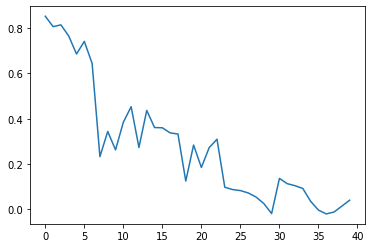

In [ ]:
imp
plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [ ]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [ ]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
len(data_set), len(data_loader)

(1, 1)

## Visualization

In [ ]:
data.head()

,Price_wti,Vol_wti,date,Price_us2bond
0,106.17,175.47,2014-06-23,0.468
1,106.03,175.21,2014-06-24,0.460
2,106.50,249.06,2014-06-25,0.484
3,105.84,195.72,2014-06-26,0.469
4,105.74,128.98,2014-06-27,0.465


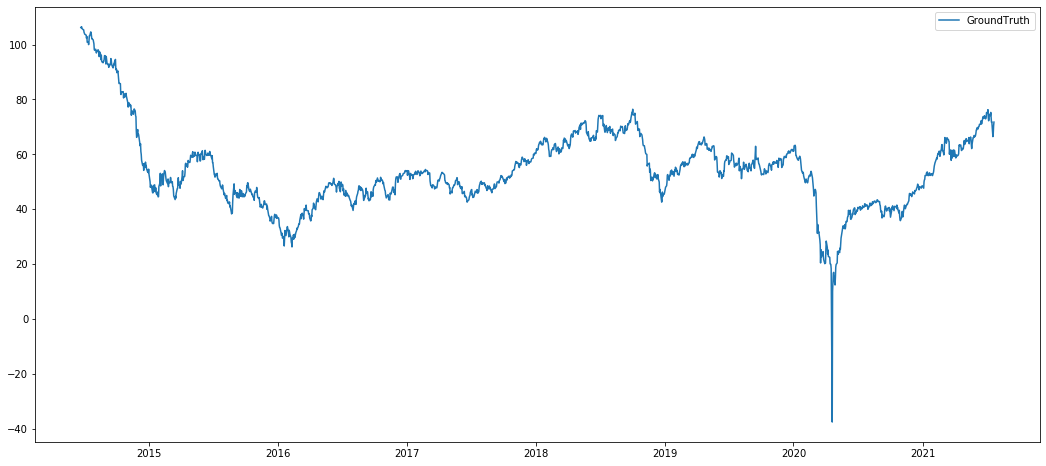

In [ ]:
# data.date= pd.to_datetime(data.date)

import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.plot(data.date, data.Price_wti, label='GroundTruth')
plt.legend()
plt.show()

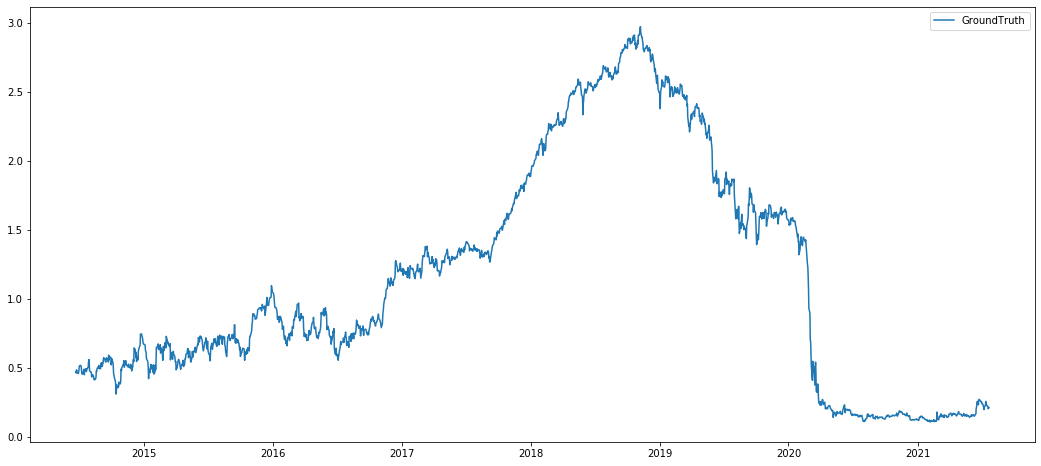

In [ ]:
# data.date= pd.to_datetime(data.date)

import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.plot(data.date, data.Price_us2bond, label='GroundTruth')
plt.legend()
plt.show()

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)
import numpy as np
setting = "informer_0723_custom_ftMS_sl240_ll120_pl10_dm512_nh12_el8_dl4_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0"
preds = np.load('./results/'+setting+'/pred.npy')
# real_pred = np.load('./results/'+setting+'/real_prediction.npy')
trues = np.load('./results/'+setting+'/true.npy')

# trues_1 = trues[:,0,0].ravel()
# preds_1 = preds[:,0,0].ravel()
# trues_2 = trues[:,0,1].ravel()
# preds_2 = preds[:,0,1].ravel()
# trues_6 = trues[:,0,2].ravel()
# preds_6 = preds[:,0,2].ravel()
# [samples, pred_len, dimensions]
preds_1.shape, trues.shape

((352,), (352, 10, 1))

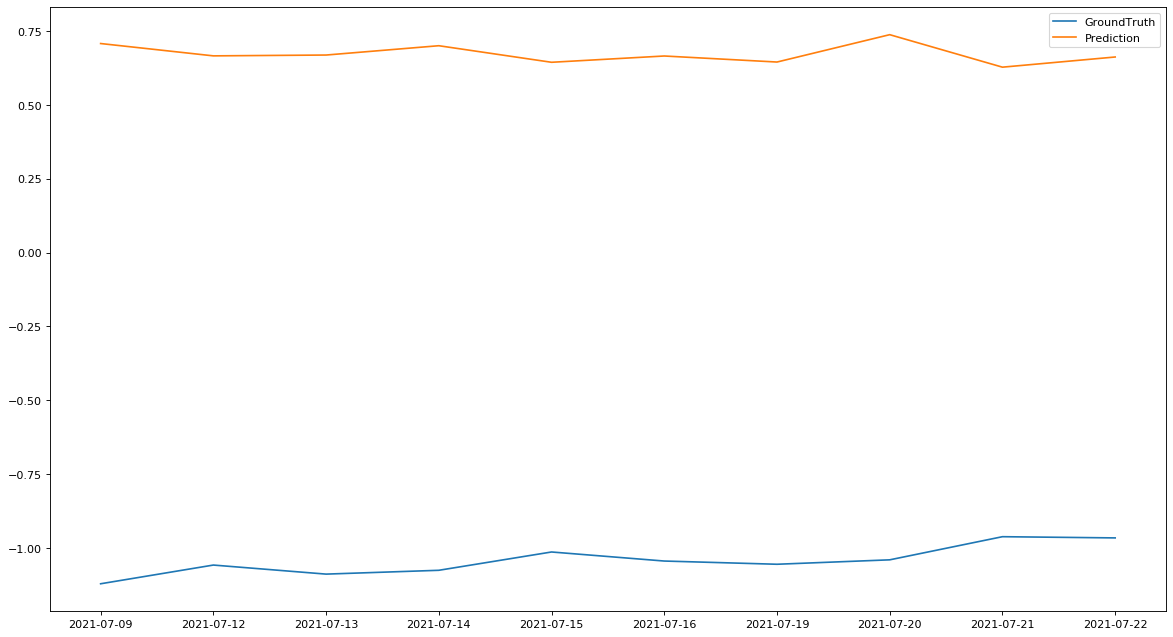

In [ ]:
# us 2bond와
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(data.date[-10:], trues[100,:,-1], label='GroundTruth')
plt.plot(data.date[-10:], preds[100,:,-1], label='Prediction')
plt.legend()
plt.show()

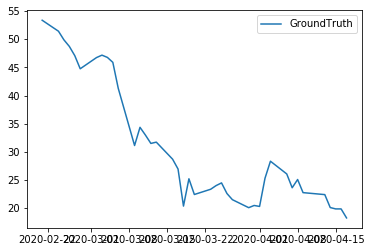

In [ ]:
# plt.plot(trues[0,:,2], label='GroundTruth')
plt.plot(data.date[-372:-332 ], data.Price_wti[-372:-332], label='GroundTruth')

plt.legend()
plt.show()

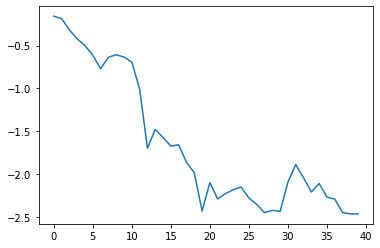

In [ ]:
plt.plot(trues[0,:,-1], label='GroundTruth')


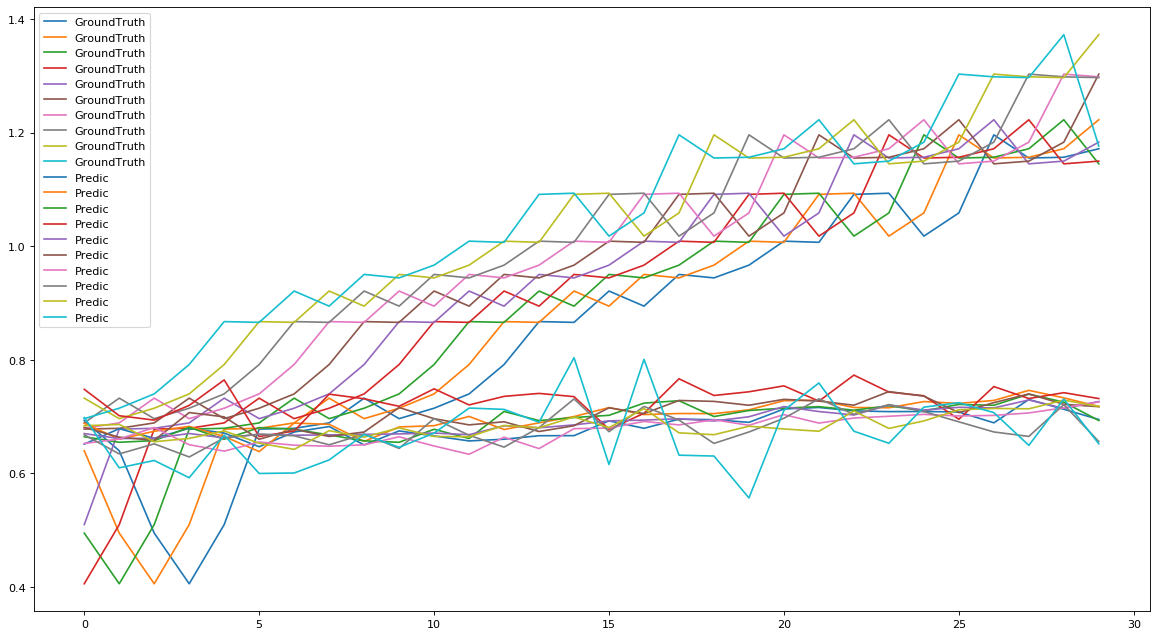

In [ ]:
# us 2bond와
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(trues[-30:,:,-1], label='GroundTruth')
plt.plot(preds[-30:,:,-1], label='Predic')

plt.legend()
plt.show()

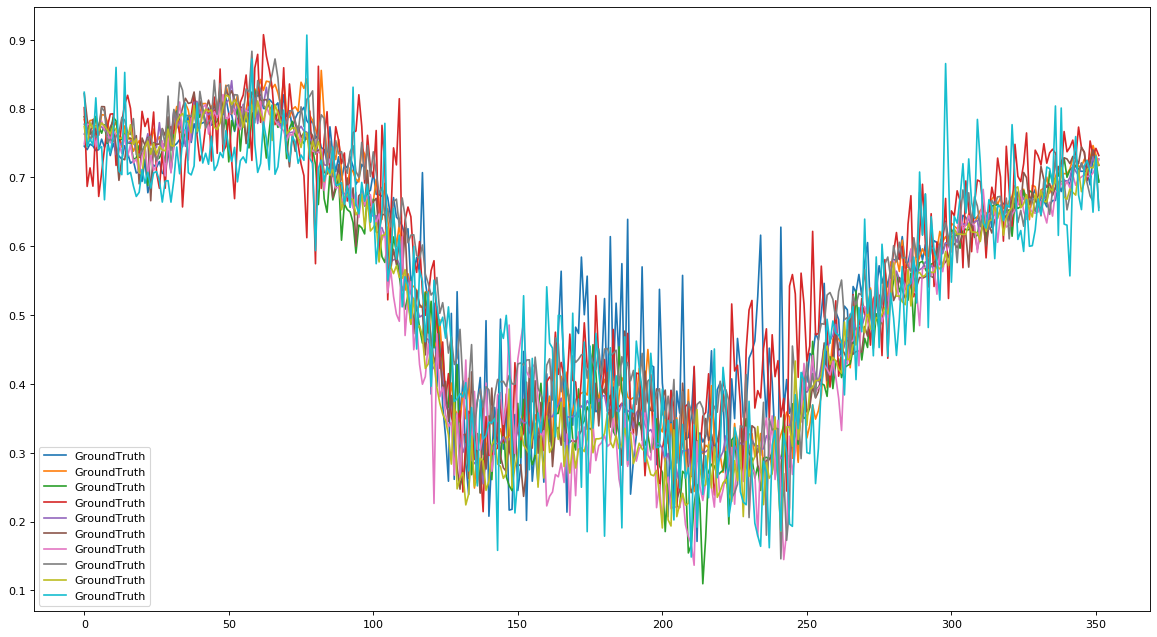

In [ ]:
# us 2bond와
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(preds[:,:,-1], label='GroundTruth')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(data.date[-352:], data.Price[-352:], label='GroundTruth')

plt.legend()
plt.show()

NameError: ignored

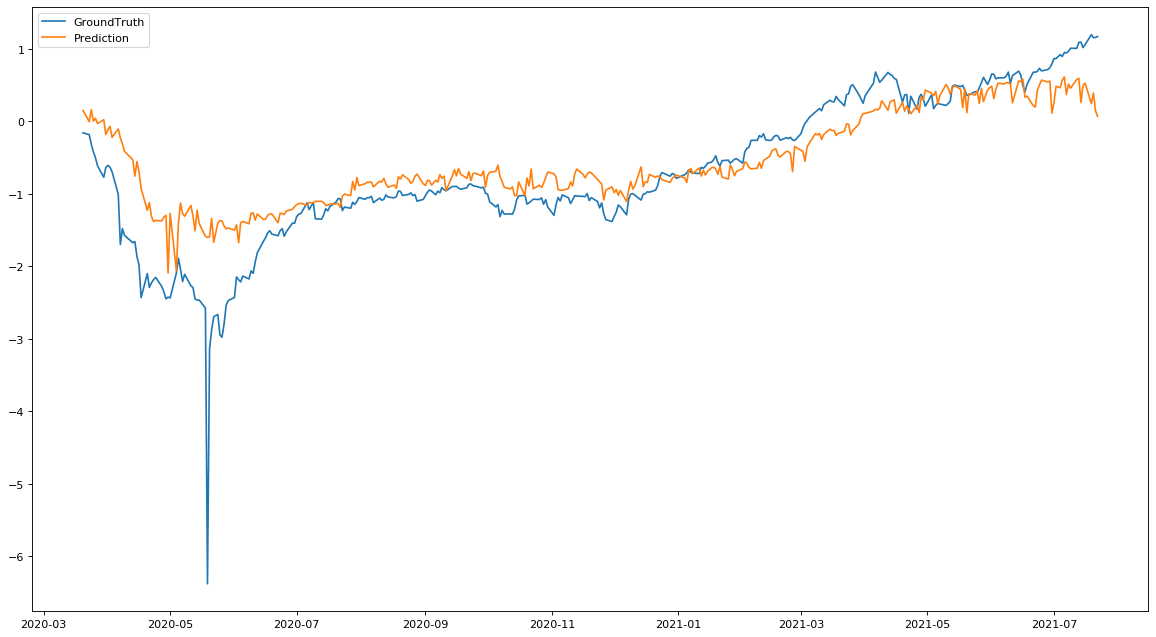

In [ ]:
# us 2bond와
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(data.date[-352:], trues_6, label='GroundTruth')
plt.plot(data.date[-352:], preds_6, label='Prediction')
plt.legend()
plt.show()

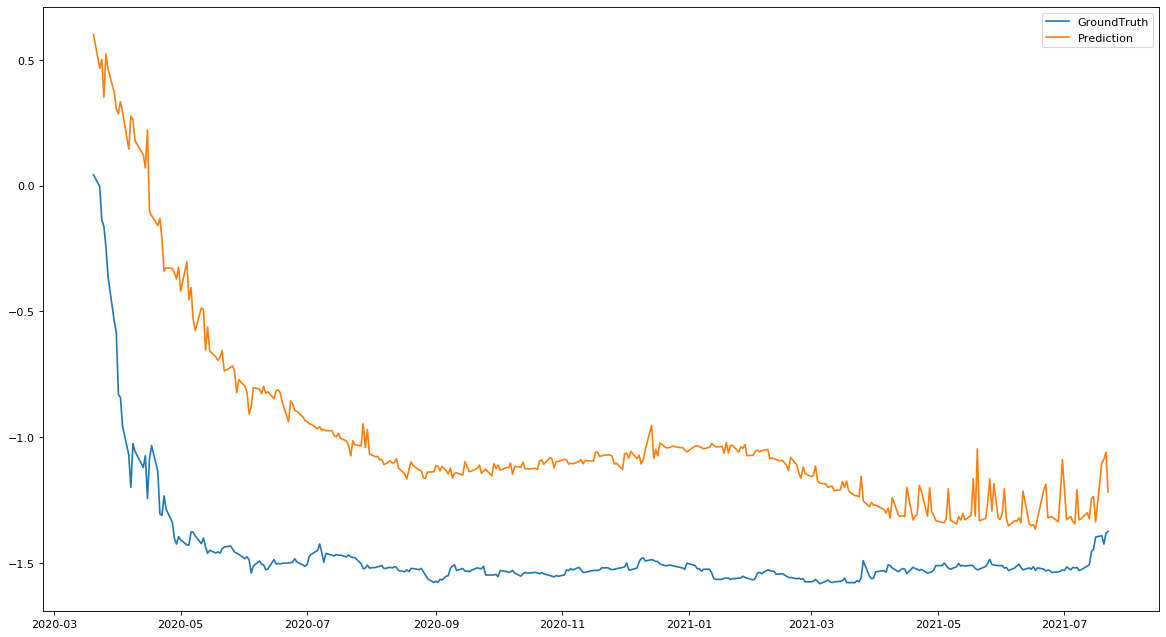

In [ ]:
# us 2bond와
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(data.date[-352:], trues_2, label='GroundTruth')
plt.plot(data.date[-352:], preds_2, label='Prediction')
plt.legend()
plt.show()

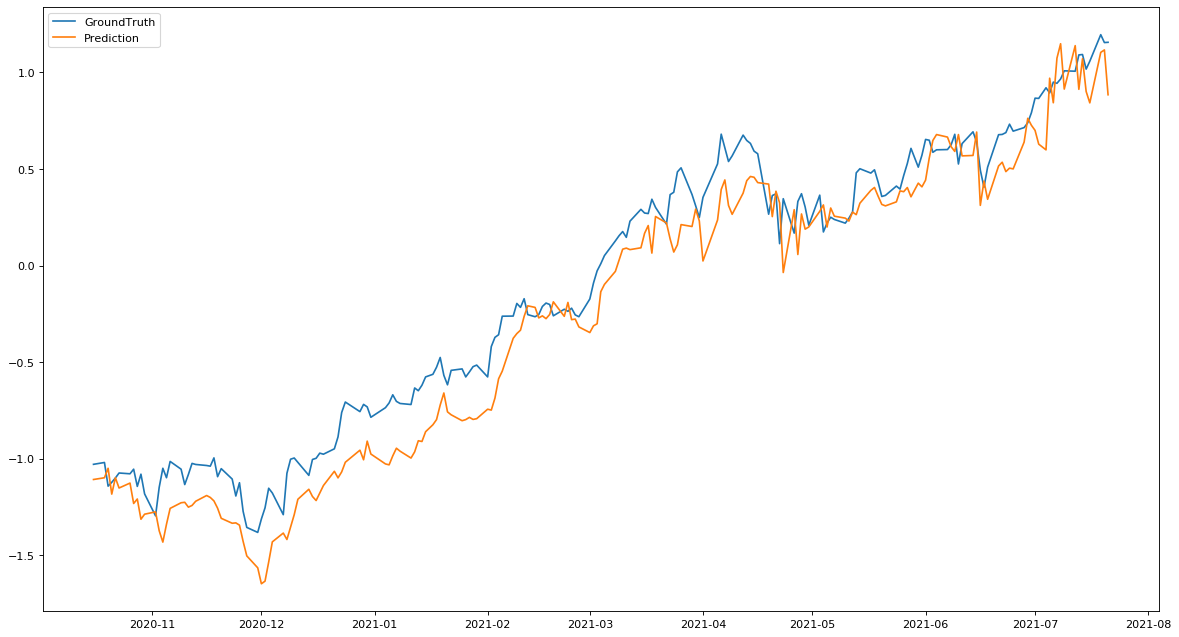

In [ ]:
# change
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(data.date[-200:], trues_6[-200:], label='GroundTruth')
plt.plot(data.date[-200:], preds_6[-200:], label='Prediction')
plt.legend()
plt.show()

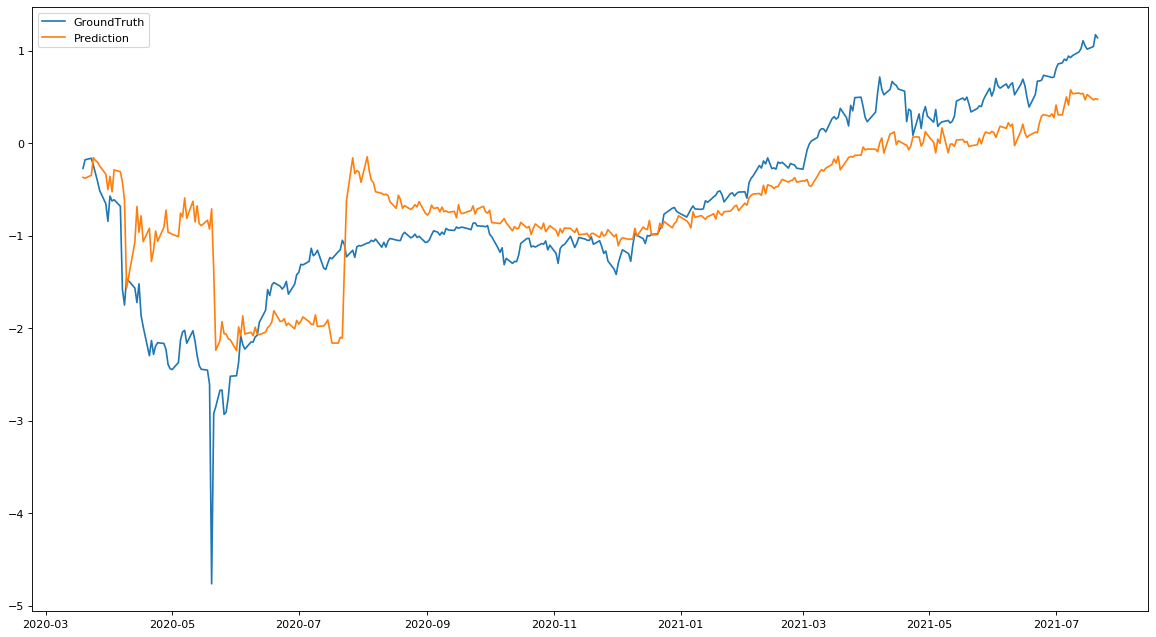

In [ ]:

# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(data.date[-352:], trues_1, label='GroundTruth')
plt.plot(data.date[-352:], preds_1, label='Prediction')
plt.legend()
plt.show()


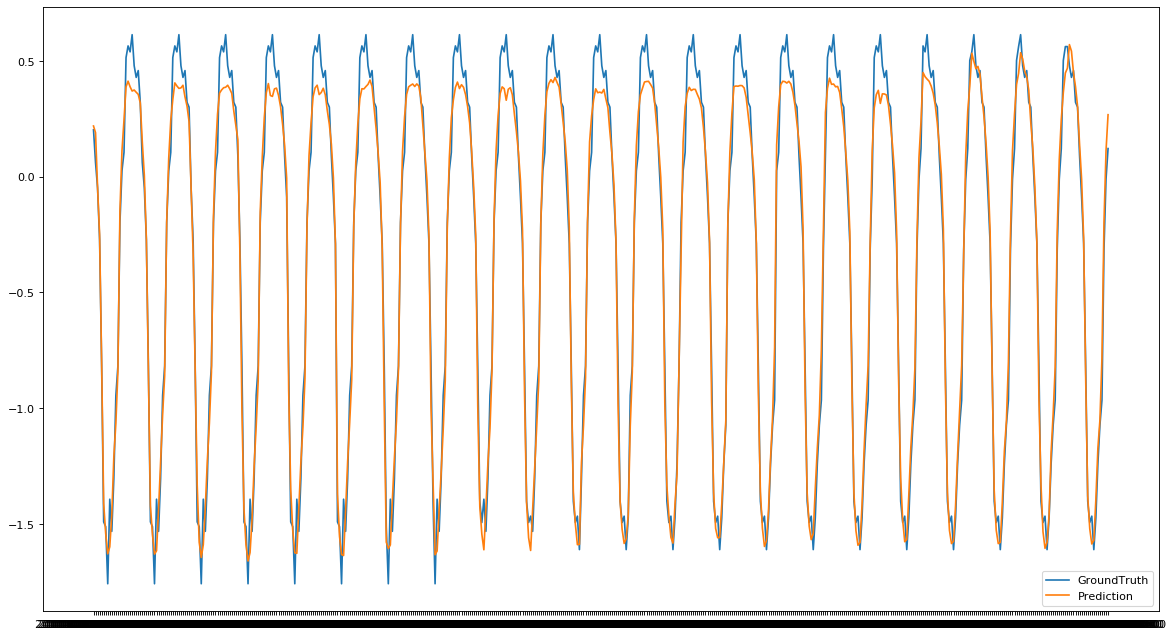

In [ ]:
# draw MT 500 
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(df.date[:500], trues_1[:500], label='GroundTruth')
plt.plot(df.date[:500], preds_1[:500], label='Prediction')
plt.legend()
plt.show()

In [ ]:
setting

'informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'

In [ ]:
real_pred.shape

(1, 24, 7)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

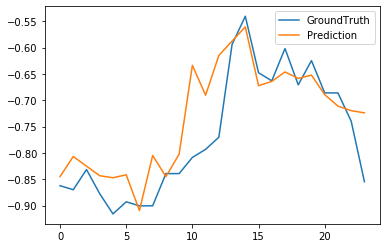

In [ ]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

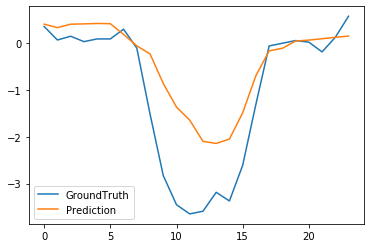

In [ ]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

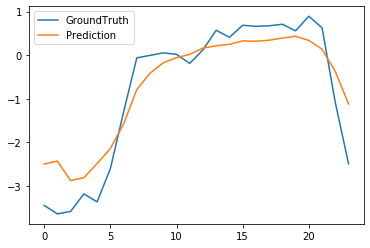

In [ ]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[10,:,0], label='GroundTruth')
plt.plot(preds[10,:,0], label='Prediction')
plt.legend()
plt.show()

In [ ]:
df.head()
df.date= pd.to_datetime(df.date)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
date    17420 non-null datetime64[ns]
HUFL    17420 non-null float64
HULL    17420 non-null float64
MUFL    17420 non-null float64
MULL    17420 non-null float64
LUFL    17420 non-null float64
LULL    17420 non-null float64
OT      17420 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.1 MB


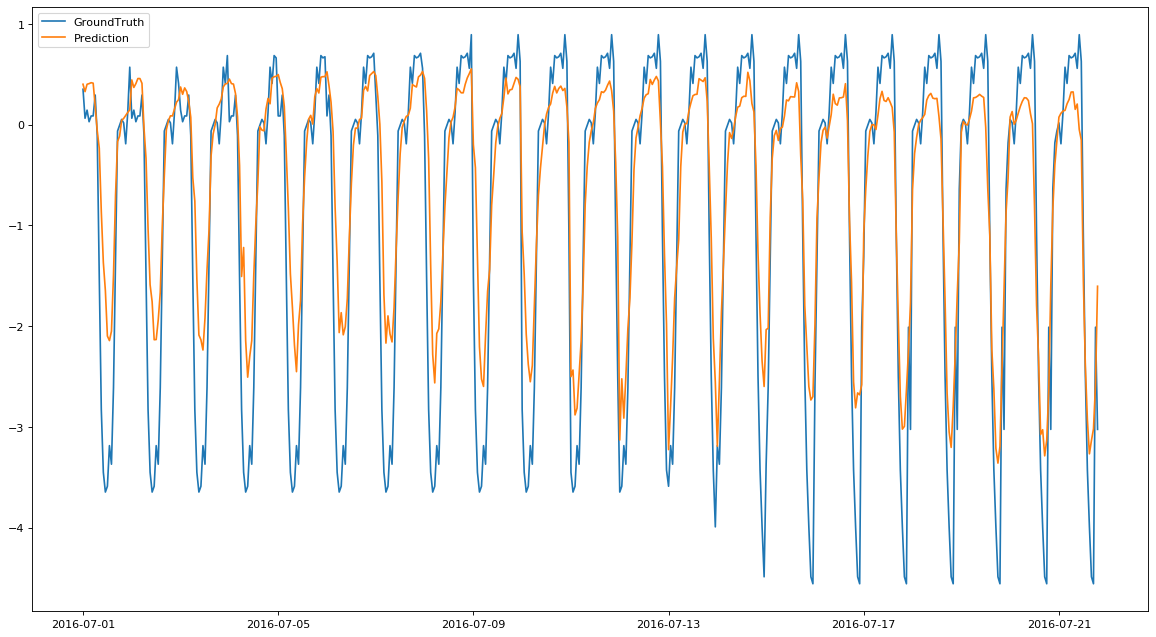

In [ ]:
# draw HUFL prediction
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(df.date[:500], trues_1[:500], label='GroundTruth')
plt.plot(df.date[:500], preds_1[:500], label='Prediction')
plt.legend()
plt.show()

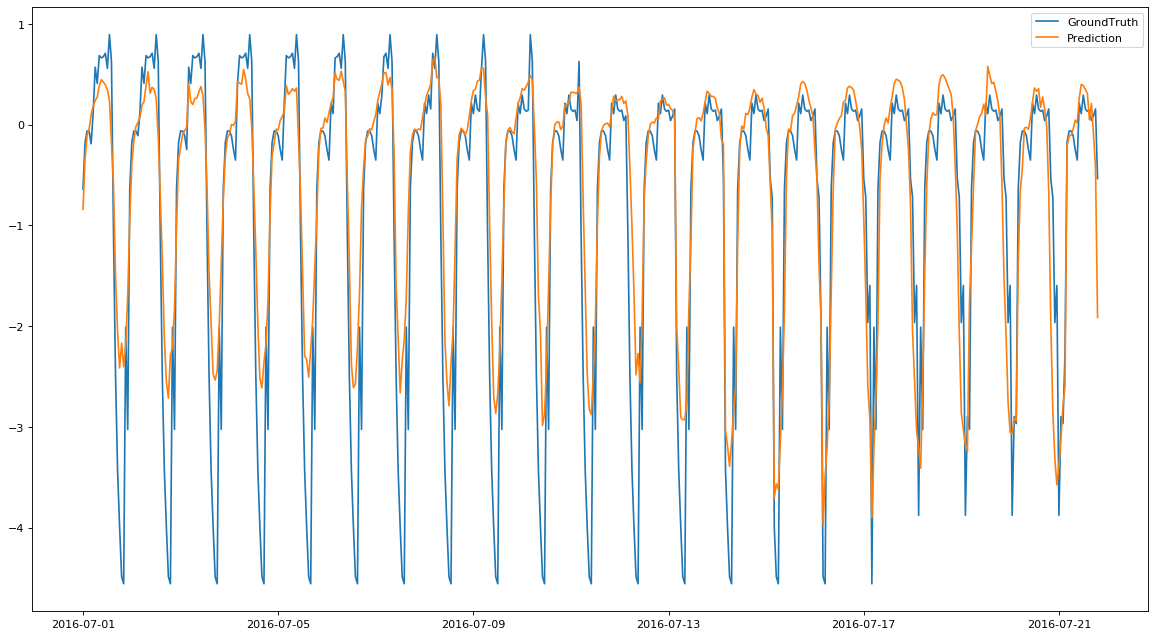

In [ ]:
# draw HUFL prediction
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(df.date[:500], trues_1[500:1000], label='GroundTruth')
plt.plot(df.date[:500], preds_1[500:1000], label='Prediction')
plt.legend()
plt.show()

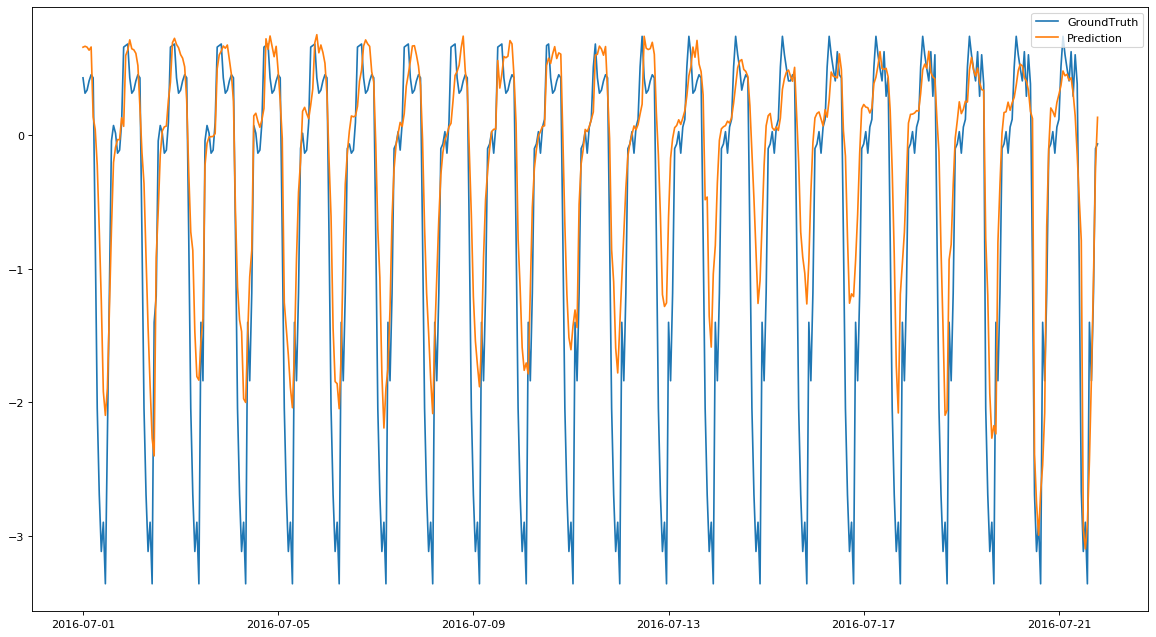

In [ ]:
# draw HUFL prediction
# 날짜는 임의로 넣은것 
plt.figure(figsize=(18, 10), dpi=80)
plt.plot(df.date[:500], trues_1[1500:2000], label='GroundTruth')
plt.plot(df.date[:500], preds_1[1500:2000], label='Prediction')
plt.legend()
plt.show()

In [ ]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
import os

args.output_attention = True

exp = Exp(args)

model = exp.model

setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
model.load_state_dict(torch.load(path))

Use GPU: cuda:0


<All keys matched successfully>

In [ ]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [ ]:
attn[0].shape, attn[1].shape #, attn[2].shape

(torch.Size([1, 8, 96, 96]), torch.Size([1, 8, 49, 49]))

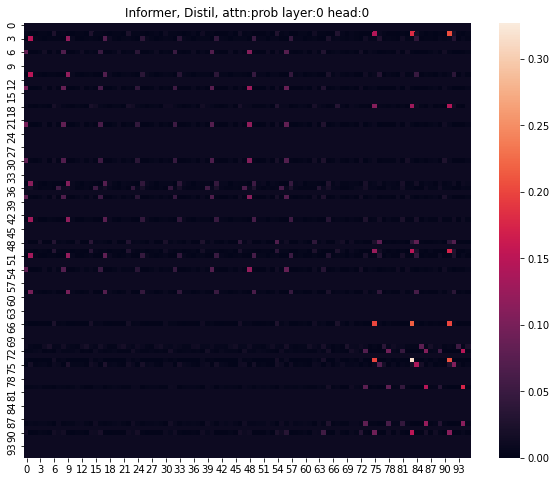

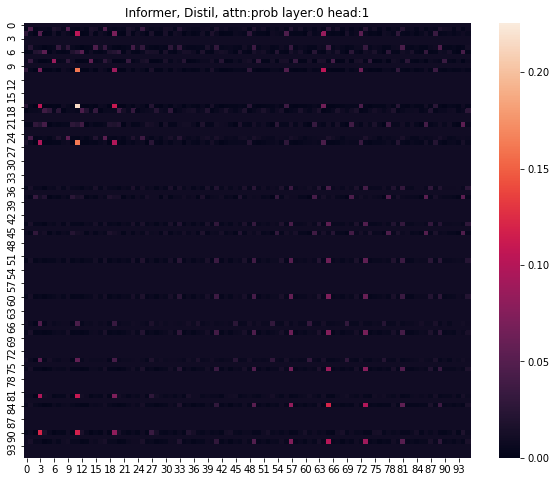

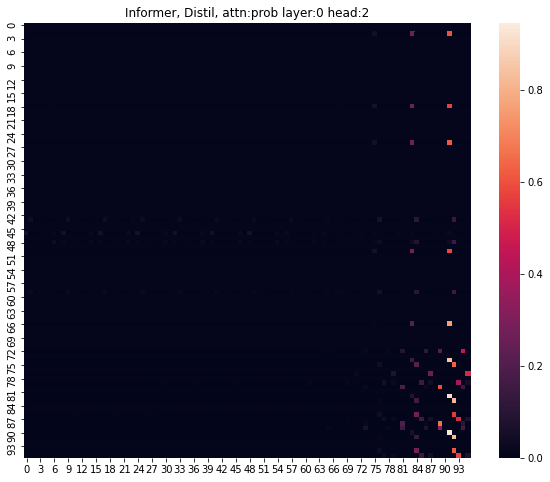

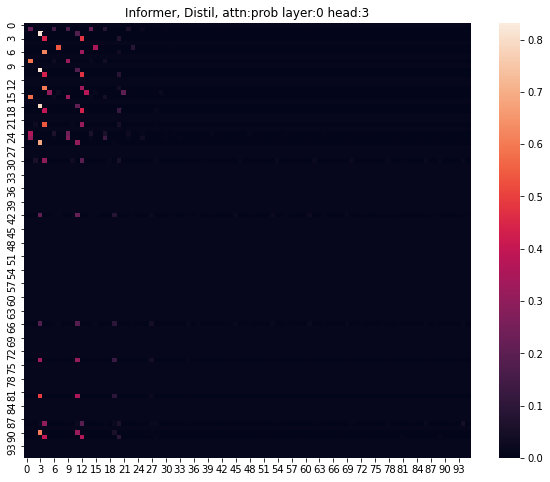

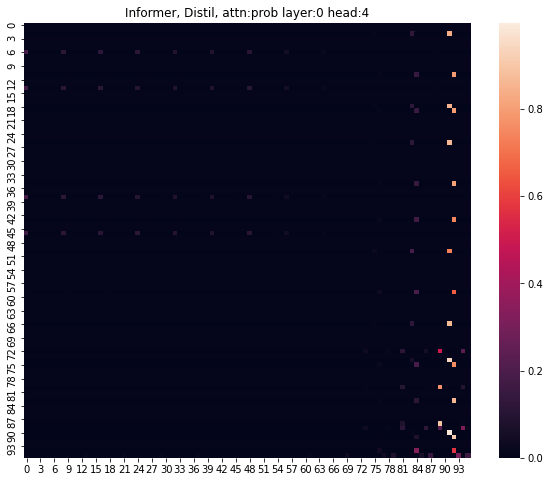

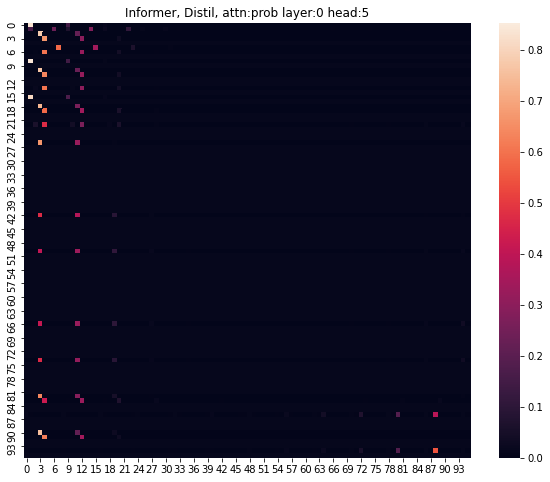

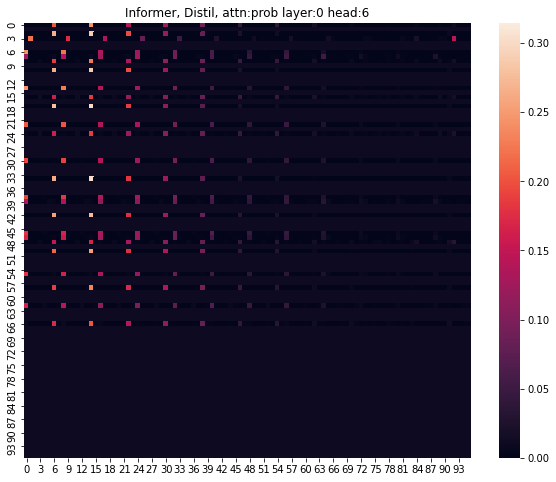

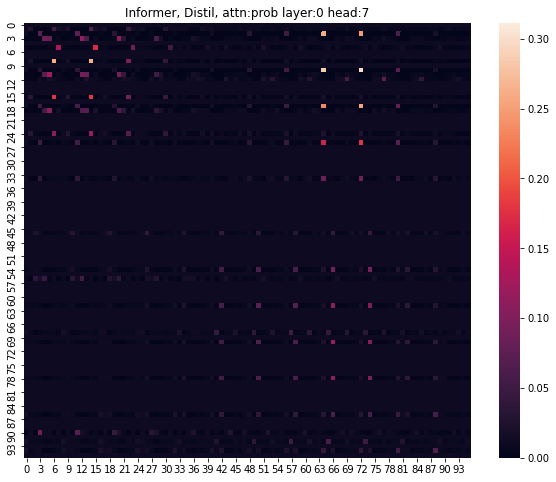

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

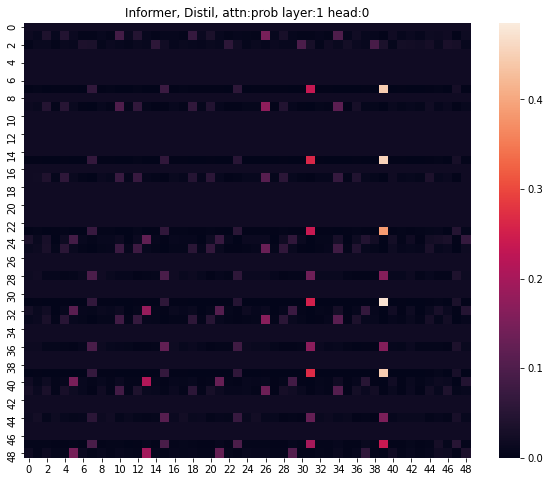

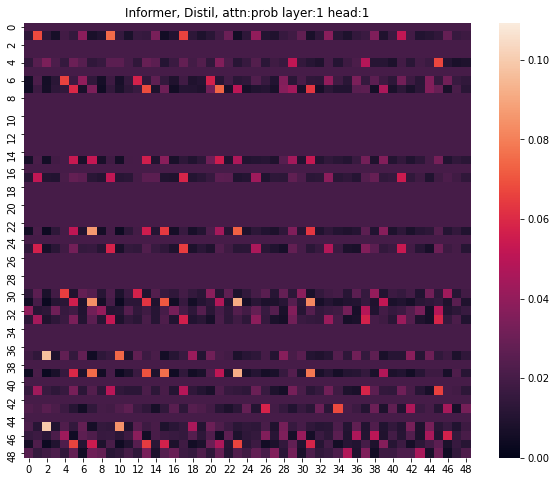

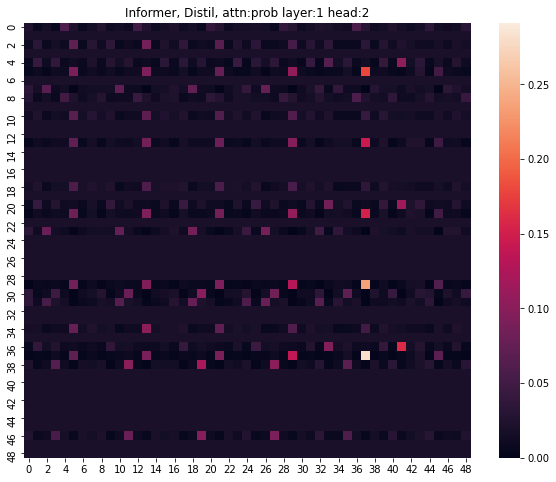

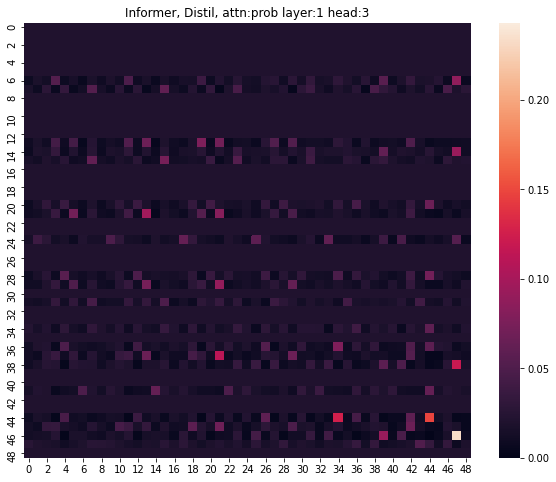

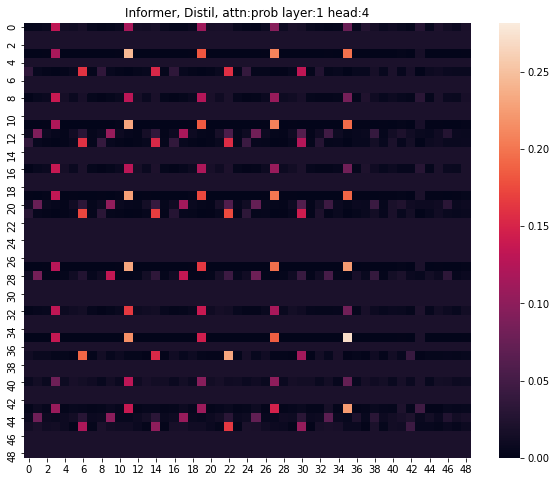

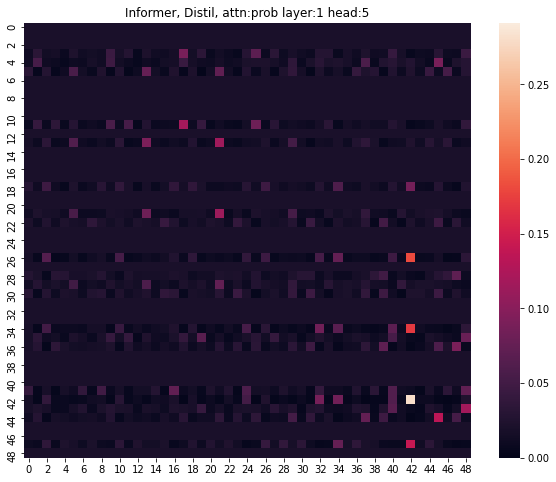

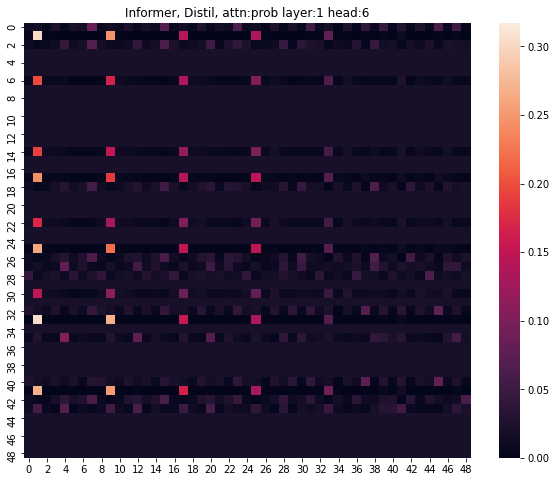

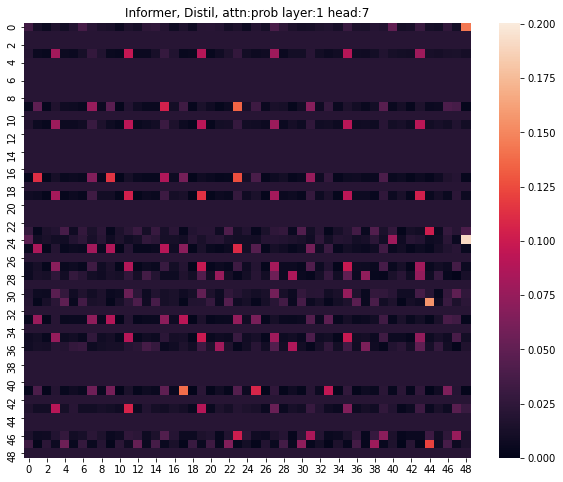

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './'
args.data_path = 'LD_MT200_hour_full.csv'


df = pd.read_csv(os.path.join(args.root_path, args.data_path))


In [ ]:
df.head()

,date,MT_200
0,2011-01-01 00:00:00,1247.797357
1,2011-01-01 01:00:00,1475.770925
2,2011-01-01 02:00:00,1397.577093
3,2011-01-01 03:00:00,1363.436123
4,2011-01-01 04:00:00,1314.977974


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35065 entries, 0 to 35064
Data columns (total 2 columns):
date      35065 non-null object
MT_200    35065 non-null float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB


In [ ]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'MT_200'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[1]

In [ ]:
batch_x.shape
len(data_set)

6990

In [ ]:
print(batch_x.shape,batch_x_mark.shape)

(96, 1) (96, 4)


In [ ]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'HULL'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)